# Step 2 - Cleaning step and sleep data and looking for trends

This notebook explains how Fitbit data may be cleaned by removing clear outliers. We will furthermore look for trends in the step and sleep data. Note that all analysis performed here is rather simple and can be seen as first steps in a more sophisticated workflow.

## Getting and cleaning step data

Let's start with downloading and visualizing my daily step data - a process that was already discussed in Step 1 of this analysis. The following code snippet downloads my daily step data over the last three months and prints today's step count as an example.

In [1]:
import fitbit
from bin.parse_credentials import parse_client_credentials, parse_tokens

client_id, client_secret = parse_client_credentials('client_id_secret.txt')

!./gather_keys_oauth2.py $client_id $client_secret >access_refresh_tokens.txt 2>/dev/null

access_token, refresh_token = parse_tokens('access_refresh_tokens.txt')

authd_client = fitbit.Fitbit(client_id, client_secret, oauth2=True,
                             access_token=access_token,
                             refresh_token=refresh_token)

steps_ts = authd_client.time_series('activities/steps', period='3m')
steps_ts['activities-steps'][-1]

{'dateTime': '2016-03-28', 'value': '14241'}

Next, we convert all dates to Python [datetime](https://docs.python.org/3/library/datetime.html#module-datetime) objects.

In [2]:
import dateutil.parser
date_steps = [(dateutil.parser.parse(date_steps_dict['dateTime']), int(date_steps_dict['value']))
              for date_steps_dict in steps_ts['activities-steps']]
date_steps[-1]

(datetime.datetime(2016, 3, 28, 0, 0), 14241)

As a last step prior to taking an initial look at the daily step counts, the step data are stored as a [pandas](http://pandas.pydata.org/) DataFrame. This will simplify the downstream analyses and facilitates simple data visualizations. The last five rows of the resulting DataFrame looks like this:

In [3]:
import pandas

date_steps_df = pandas.DataFrame(date_steps, columns=('Date', 'Steps'))
date_steps_df.tail()

,Date,Steps
88,2016-03-24,5210
89,2016-03-25,13451
90,2016-03-26,17618
91,2016-03-27,9304
92,2016-03-28,14241


We also import the [seaborn](https://stanford.edu/~mwaskom/software/seaborn/) library to make the plots look a little more attractive and then plot the daily steps for each day.

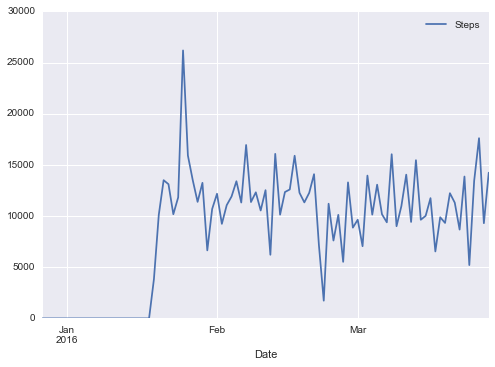

In [4]:
%matplotlib inline
import seaborn

date_steps_df.plot(x='Date')

To clean the step data, let's remove all days with fewer than 5000 steps. This mostly removes days before I started tracking my steps and also an outlier day with very few steps where I may have taken off the wristband in the middle of the day.

We furthermore remove an outlier day with unusually high step count by restricting to days with 20000 steps or less.

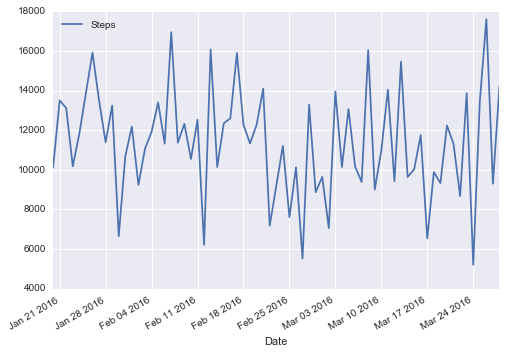

In [5]:
keep_rows = date_steps_df.Steps >= 5000
keep_rows = keep_rows.combine(date_steps_df.Steps <= 20000, lambda x,y: x and y)
date_steps_df = date_steps_df[keep_rows]

date_steps_df.plot(x='Date')

## Getting and cleaning sleep data

We will now download and visualize my daily sleep data following the process explained in Step 1 of this tutorial.

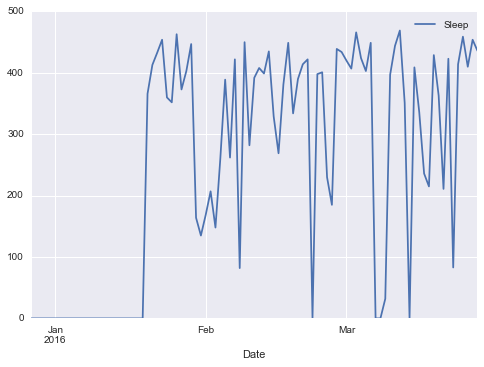

In [6]:
sleep_ts = authd_client.time_series('sleep/minutesAsleep', period='3m')
sleep_ts['sleep-minutesAsleep'][-7]
date_sleep = [(dateutil.parser.parse(date_sleep_dict['dateTime']), int(date_sleep_dict['value']))
              for date_sleep_dict in sleep_ts['sleep-minutesAsleep']]
date_sleep_df = pandas.DataFrame(date_sleep, columns=('Date', 'Sleep'))
date_sleep_df.plot(x='Date')

We observe that the number of minutes asleep seems quite low on many days (or, equivalently, nights) over the last three months. For instance, there are many days with three hours of sleep, also there are only very few days with more than seven hours of sleep. Knowing my own sleep behaviour, this seems wrong.

What's going on? Let's look for duplicated dates first that could indicate that some of the dates are repeated hence breaking up the sleep data into several entries for the same day.

In [7]:
date_series = date_sleep_df.Date
len(date_series.unique()) == len(date_series)

True

Nope, days are not broken up as no dates are duplicated.

Let's look at the detailed daily sleep logs, instead of sleep time series data, offered for download by the [Fitbit API](https://dev.fitbit.com/docs/sleep/#get-sleep-logs). Detailed sleep logs for all dates covered by sleep time series data are downloaded by the following command:

In [8]:
sleep_daily = [authd_client.sleep(date) for date in date_series]

We see that daily sleep logs actually offer a **lot** of additional information with minute resolution. Warning: long output ahead, just scroll down to the next code snippet.

In [9]:
sleep_daily[-1]

{'sleep': [{'awakeCount': 1,
   'awakeDuration': 4,
   'awakeningsCount': 30,
   'dateOfSleep': '2016-03-28',
   'duration': 28920000,
   'efficiency': 91,
   'isMainSleep': True,
   'logId': 11239706727,
   'minuteData': [{'dateTime': '22:04:00', 'value': '1'},
    {'dateTime': '22:05:00', 'value': '1'},
    {'dateTime': '22:06:00', 'value': '1'},
    {'dateTime': '22:07:00', 'value': '1'},
    {'dateTime': '22:08:00', 'value': '2'},
    {'dateTime': '22:09:00', 'value': '1'},
    {'dateTime': '22:10:00', 'value': '1'},
    {'dateTime': '22:11:00', 'value': '2'},
    {'dateTime': '22:12:00', 'value': '1'},
    {'dateTime': '22:13:00', 'value': '1'},
    {'dateTime': '22:14:00', 'value': '1'},
    {'dateTime': '22:15:00', 'value': '1'},
    {'dateTime': '22:16:00', 'value': '1'},
    {'dateTime': '22:17:00', 'value': '1'},
    {'dateTime': '22:18:00', 'value': '1'},
    {'dateTime': '22:19:00', 'value': '1'},
    {'dateTime': '22:20:00', 'value': '1'},
    {'dateTime': '22:21:00', 'val

In [10]:
sleep_minutes = [sleep_entry['summary']['totalMinutesAsleep'] for sleep_entry in sleep_daily]
sleep_minutes[-1]

436

We now create another DataFrame summarizing my daily sleep data as obtained by the summary returned as part of the daily sleep logs request.

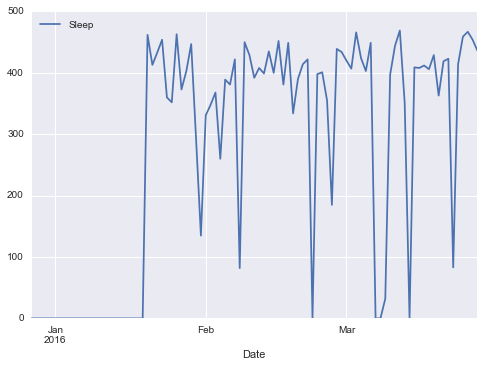

In [11]:
date_sleep_df = pandas.DataFrame({'Date': date_series, 'Sleep': sleep_minutes})
date_sleep_df.plot(x='Date')

Now the sleep data looks a little bit more complete. In particluar since I seem to be sleeping around seven hours most nights which is close to my personal estimate (I would have guessed that I sleep about 7.5 hours each night).

Let's remove the remaining dates with less than 200 minutes of sleep (intercontinental flight? tracking error? low battery?).

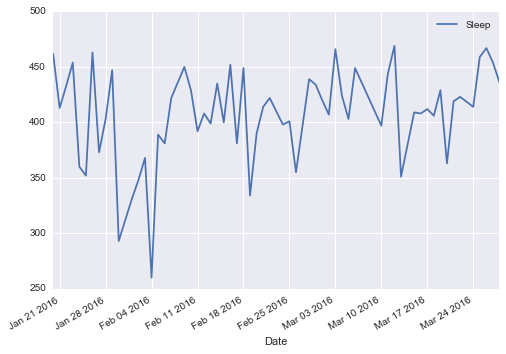

In [12]:
keep_rows = date_sleep_df.Sleep >= 200
date_sleep_df = date_sleep_df[keep_rows]
date_sleep_df.plot(x='Date')

## Trends in step and sleep data

We will now look for trends in the step and sleep data using a sliding window approach: The mean step count over 10 subsequent days is computed, also known as the rolling mean, and then plotted.

For simplicity, let's choose a window size of 10 here and note that the window size could also be picked using an approach such as [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29). Furthermore, note that the rolling mean is a quite simple approach and more sphisticated strategies, e.g., [weighted rolling means](https://en.wikipedia.org/wiki/Moving_average#Weighted_moving_average) exist.

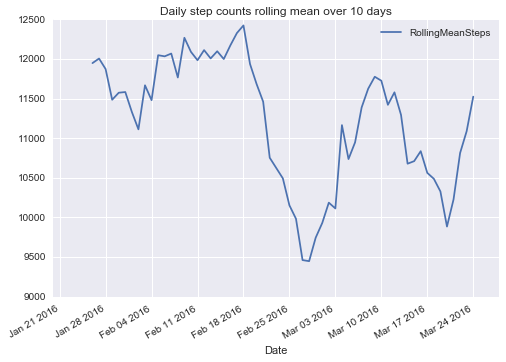

In [13]:
date_steps_df['RollingMeanSteps'] = date_steps_df.Steps.rolling(window=10, center=True).mean()
date_steps_df.plot(x='Date', y='RollingMeanSteps', title= 'Daily step counts rolling mean over 10 days')

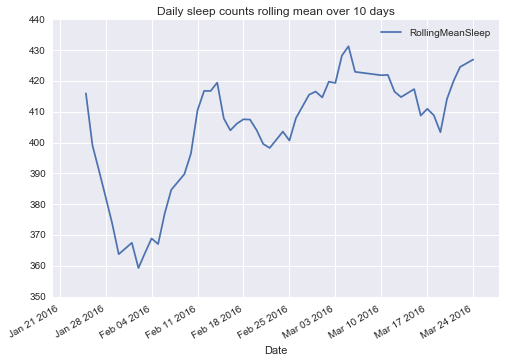

In [14]:
date_sleep_df['RollingMeanSleep'] = date_sleep_df.Sleep.rolling(window=10, center=True).mean()
date_sleep_df.plot(x='Date', y='RollingMeanSleep', title= 'Daily sleep counts rolling mean over 10 days')

## Next steps

Before drawing conclusions about potential correlations between my daily step and sleep data, I would like to gather additional data over the next months and then return to this analysis. The reason is that I do not think that I can draw valuable conclusions from only two months of data right now. Once I collected more data, I would furthermore like to investigate whether my activity and sleep patterns depend on the day of the week. 